### 温度预测问题

[数据来源:天气时间序列数据集](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

#### 观察数据

In [1]:
import os

data_dir = 'data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

data = open(fname, 'r', encoding='utf-8').read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


#### 解析数据

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

#### 绘制温度时间序列

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

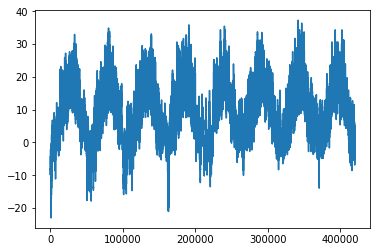

In [4]:
temp = float_data[:, 1]    # 温度(单位:摄氏度)
plt.plot(range(len(temp)), temp)

#### 绘制前 10 天的温度时间序列

每 10 分钟记录一次, 每天 144 个数据点

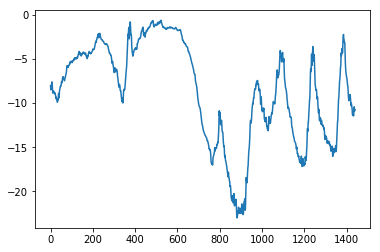

In [5]:
plt.plot(range(1440), temp[:1440])

### 准备数据

#### 数据标准化

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

#### 生成时间序列样本及其目标的生成器

In [7]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=True, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#### 准备训练生成器、验证生成器和测试生成器

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000,
                    step=step, 
                    batch_size=batch_size)
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None,
                     step=step, 
                     batch_size=batch_size)

In [9]:
test_gen.__next__()[0].shape

(128, 240, 14)

为了查看整个验证集和测试集，需要从 val_gen 和 test_gen 中抽取多少次

In [10]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 一种基于常识的、非机器学习的基准方法

#### 计算符合常识的基准方法的 MAE

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)
    
evaluate_naive_method()

0.28877817001804956

#### 将 MAE 转换成摄氏温度误差

In [12]:
celsius_mae = evaluate_naive_method() * std[1]
celsius_mae

2.567987138328999

### 一种基本的机器学习方法

#### 训练并评估一个密集连接模型

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 19s 38ms/step - loss: 1.0589 - val_loss: 0.4709
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.4106 - val_loss: 0.3193
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2963 - val_loss: 0.3162
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2700 - val_loss: 0.3052
Epoch 5/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2551 - val_loss: 0.3045
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2468 - val_loss: 0.3494
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2407 - val_loss: 0.3287
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2347 - val_loss: 0.3079
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2315 - val_loss: 0.3376
Epoch 10/20
500/500 [==============================] - 12s 24ms/step - loss: 0.224

#### 绘制结果

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

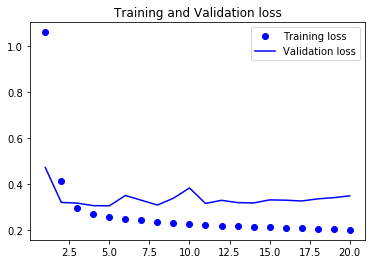

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### 第一个循环网络基准

#### 训练并评估一个基于 GRU 的模型

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 179s 358ms/step - loss: 0.3079 - val_loss: 0.2729
Epoch 2/20
500/500 [==============================] - 180s 361ms/step - loss: 0.2856 - val_loss: 0.2675
Epoch 3/20
500/500 [==============================] - 182s 363ms/step - loss: 0.2811 - val_loss: 0.2627
Epoch 4/20
500/500 [==============================] - 177s 354ms/step - loss: 0.2717 - val_loss: 0.2652
Epoch 5/20
500/500 [==============================] - 188s 375ms/step - loss: 0.2665 - val_loss: 0.2644
Epoch 6/20
500/500 [==============================] - 183s 365ms/step - loss: 0.2620 - val_loss: 0.2623
Epoch 7/20
500/500 [==============================] - 185s 370ms/step - loss: 0.2576 - val_loss: 0.2681
Epoch 8/20
500/500 [==============================] - 189s 377ms/step - loss: 0.2539 - val_loss: 0.2647
Epoch 9/20
500/500 [==============================] - 190s 381ms/step - loss: 0.2469 - val_loss: 0.2702
Epoch 10/20
500/500 [==============================] - 185s 370m

#### 绘制结果

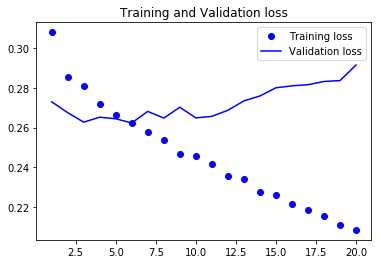

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### 使用循环 dropout 来降低过拟合

#### 训练并评估一个使用 dropout 正则化的基于 GRU 的模型

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=40, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 208s 415ms/step - loss: 0.3346 - val_loss: 0.2781
Epoch 2/40
500/500 [==============================] - 223s 445ms/step - loss: 0.3181 - val_loss: 0.2684
Epoch 3/40
500/500 [==============================] - 206s 412ms/step - loss: 0.3111 - val_loss: 0.2746
Epoch 4/40
500/500 [==============================] - 206s 412ms/step - loss: 0.3043 - val_loss: 0.2754
Epoch 5/40
500/500 [==============================] - 219s 438ms/step - loss: 0.3018 - val_loss: 0.2684
Epoch 6/40
500/500 [==============================] - 210s 420ms/step - loss: 0.2971 - val_loss: 0.2668
Epoch 7/40
500/500 [==============================] - 216s 432ms/step - loss: 0.2953 - val_loss: 0.2661
Epoch 8/40
500/500 [==============================] - 218s 435ms/step - loss: 0.2938 - val_loss: 0.2686
Epoch 9/40
500/500 [==============================] - 214s 429ms/step - loss: 0.2908 - val_loss: 0.2733
Epoch 10/40
500/500 [==============================] - 213s 426m

#### 绘制结果

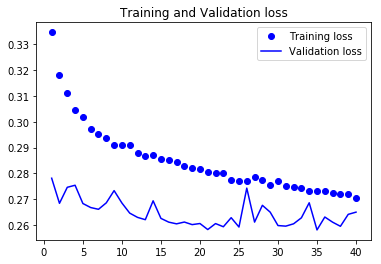

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### 循环层堆叠

#### 训练并评估一个使用 dropout 正则化的堆叠 GRU 模型

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                    dropout=0.1,
                    recurrent_dropout=0.5, 
                    return_sequences=True, 
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', 
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

In [ ]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=40, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

### 使用双向 RNN

#### 使用逆序序列训练并评估一个 LSTM

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

# 载入数据
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 序列反转
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 填充序列
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

# 构建模型
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

#### 训练并评估一个双向 LSTM

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

#### 训练一个双向 GRU

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=40, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)